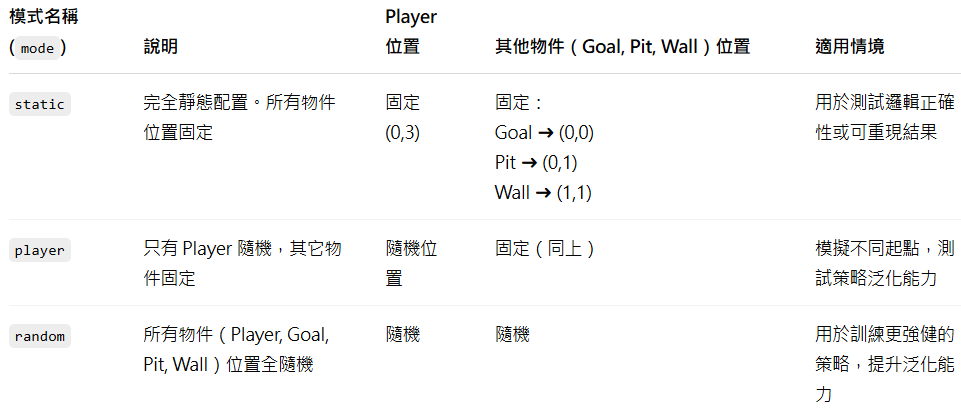

## HW4-1: Naive DQN  for static mode

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# 下載 Gridworld.py 及 GridBoard.py (-q 是設為安靜模式)
!wget -q https://github.com/DeepReinforcementLearning/DeepReinforcementLearningInAction/raw/master/Errata/Gridworld.py
!wget -q https://github.com/DeepReinforcementLearning/DeepReinforcementLearningInAction/raw/master/Errata/GridBoard.py

from Gridworld import Gridworld
game = Gridworld(size=4, mode='static')

In [ ]:
import numpy as np
import torch
from Gridworld import Gridworld
from IPython.display import clear_output
import random
from matplotlib import pylab as plt

L1 = 64 #輸入層的寬度
L2 = 150 #第一隱藏層的寬度
L3 = 100 #第二隱藏層的寬度
L4 = 4 #輸出層的寬度

model = torch.nn.Sequential(
    torch.nn.Linear(L1, L2), #第一隱藏層的shape
    torch.nn.ReLU(),
    torch.nn.Linear(L2, L3), #第二隱藏層的shape
    torch.nn.ReLU(),
    torch.nn.Linear(L3,L4) #輸出層的shape
)
loss_fn = torch.nn.MSELoss() #指定損失函數為MSE（均方誤差）
learning_rate = 1e-3  #設定學習率
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #指定優化器為Adam，其中model.parameters會傳回所有要優化的權重參數

gamma = 0.9 #折扣因子
epsilon = 1.0

In [ ]:
action_set = {
	0: 'u', #『0』代表『向上』
	1: 'd', #『1』代表『向下』
	2: 'l', #『2』代表『向左』
	3: 'r' #『3』代表『向右』
}

### 經訓練後達成收斂

Text(0, 0.5, 'Loss')

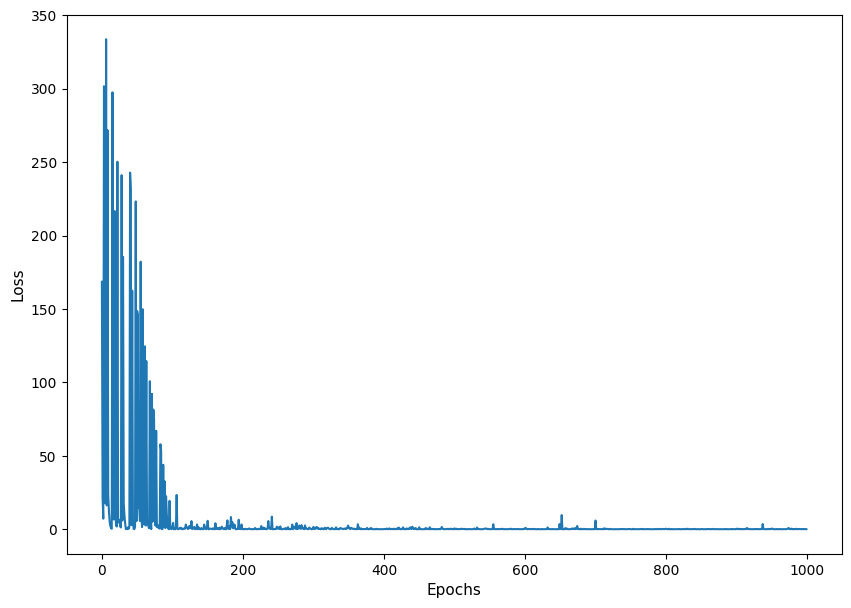

In [ ]:
epochs = 1000
losses = [] #使用串列將每一次的loss記錄下來，方便之後將loss的變化趨勢畫成圖
for i in range(epochs):
# 註解1:
  game = Gridworld(size=4, mode='static')
  state_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0 #將3階的狀態陣列（4x4x4）轉換成向量（長度為64），並將每個值都加上一些雜訊（很小的數值）。
  state1 = torch.from_numpy(state_).float() #將NumPy陣列轉換成PyTorch張量，並存於state1中
  status = 1 #用來追蹤遊戲是否仍在繼續（『1』代表仍在繼續）
  while(status == 1):
    qval = model(state1) #執行Q網路，取得所有動作的預測Q值
    qval_ = qval.data.numpy() #將qval轉換成NumPy陣列
    if (random.random() < epsilon):
      action_ = np.random.randint(0,4) #隨機選擇一個動作（探索）
    else:
      action_ = np.argmax(qval_) #選擇Q值最大的動作（探索）
    action = action_set[action_] #將代表某動作的數字對應到makeMove()的英文字母
    game.makeMove(action) #執行之前ε—貪婪策略所選出的動作
    state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    state2 = torch.from_numpy(state2_).float() #動作執行完畢，取得遊戲的新狀態並轉換成張量
    reward = game.reward()
    with torch.no_grad():
      newQ = model(state2.reshape(1,64))
    maxQ = torch.max(newQ) #將新狀態下所輸出的Q值向量中的最大值給記錄下來
    if reward == -1:
      Y = reward + (gamma * maxQ)  #計算訓練所用的目標Q值
    else: #若reward不等於-1，代表遊戲已經結束，也就沒有下一個狀態了，因此目標Q值就等於回饋值
      Y = reward
    Y = torch.Tensor([Y]).detach()
    X = qval.squeeze()[action_] #將演算法對執行的動作所預測的Q值存進X，並使用squeeze()將qval中維度為1的階去掉 (shape[1,4]會變成[4])
    loss = loss_fn(X, Y) #計算目標Q值與預測Q值之間的誤差
    if i%100 == 0:
      print(i, loss.item())
      clear_output(wait=True)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    state1 = state2
    if abs(reward) == 10:
      status = 0 # 若 reward 的絕對值為10，代表遊戲已經分出勝負，所以設status為0
  losses.append(loss.item())
  if epsilon > 0.1:
    epsilon -= (1/epochs) #讓ε的值隨著訓練的進行而慢慢下降，直到0.1（還是要保留探索的動作）
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=11)
plt.ylabel("Loss",fontsize=11)

### 建立一個環境方便觀察訓練過後的遊玩過程

In [ ]:
def test_model(model, mode='static', display=True):
    i = 0
    test_game = Gridworld(size=4, mode=mode) #產生一場測試遊戲
    state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    state = torch.from_numpy(state_).float()
    if display:
      print("Initial State:")
      print(test_game.display())
    status = 1
    while(status == 1): #遊戲仍在進行
      qval = model(state)
      qval_ = qval.data.numpy()
      action_ = np.argmax(qval_)
      action = action_set[action_]
      if display:
        print('Move #: %s; Taking action: %s' % (i, action))
      test_game.makeMove(action)
      state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
      state = torch.from_numpy(state_).float()
      if display:
        print(test_game.display())
      reward = test_game.reward()
      if reward != -1: #代表勝利（抵達終點）或落敗（掉入陷阱）
        if reward > 0: #reward>0，代表成功抵達終點
          status = 2 #將狀態設為2，跳出迴圈
          if display:
            print("Game won! Reward: %s" %reward)
          else: #掉入陷阱
            status = 0 #將狀態設為0，跳出迴圈
            if display:
              print("Game LOST. Reward: %s" %reward)
      i += 1 #每移動一步，i就加1
      if (i > 15): #若移動了15步，仍未取出勝利，則一樣視為落敗
        if display:
          print("Game lost; too many moves.")
        break
    win = True if status == 2 else False
    print(win)
    return win

### 從此例子看出static模式可穩定勝利

In [ ]:
test_model(model, 'static')

Initial State:
[['+' '-' ' ' 'P']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' 'P']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 1; Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' 'P']
 [' ' ' ' ' ' ' ']]
Move #: 2; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' 'P' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 3; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' 'P' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 4; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 ['P' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 5; Taking action: u
[['+' '-' ' ' ' ']
 ['P' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 6; Taking action: u
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Game won! Reward: 10
True


True

### 經過多次測試發現此模型在player模式仍可穩定獲勝

In [ ]:
test_model(model, 'player') #將游戲的生成模式改成player，再次測試模型

Initial State:
[['+' '-' ' ' ' ']
 ['P' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: u
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Game won! Reward: 10
True


True

### 而random模式中模型無法穩定獲勝,故需以

1. Double DQN

2. Dueling DQN

3. Keras

4. PyTorch Lightning

進行優化

In [ ]:
test_model(model, 'random') #將游戲的生成模式改成random，再次測試模型

Initial State:
[[' ' ' ' 'P' ' ']
 [' ' ' ' '+' '-']
 [' ' ' ' 'W' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: d
[[' ' ' ' ' ' ' ']
 [' ' ' ' '+' '-']
 [' ' ' ' 'W' ' ']
 [' ' ' ' ' ' ' ']]
Game won! Reward: 10
True


True

### 繪製player模式下的loss曲線(可以看出有收斂)

Text(0, 0.5, 'Loss')

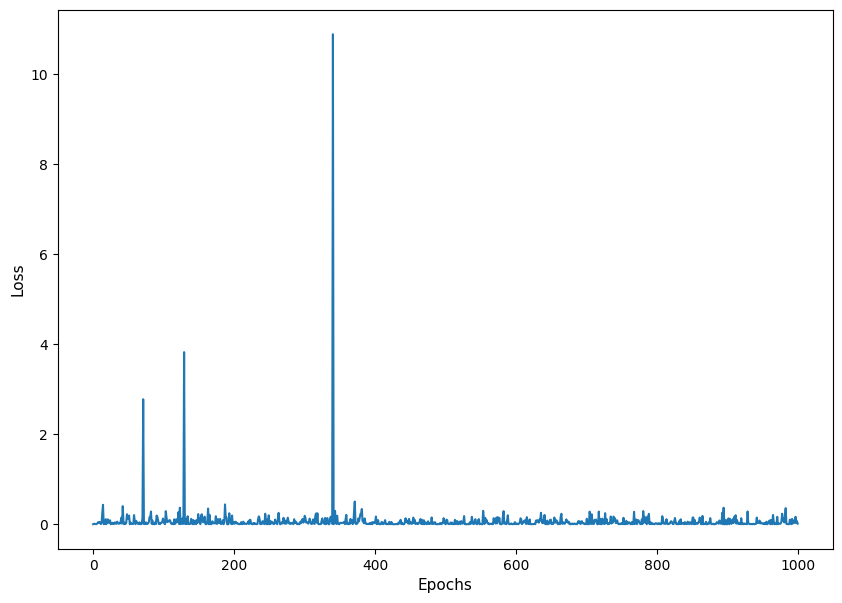

In [ ]:
epochs = 1000
losses = [] #使用串列將每一次的loss記錄下來，方便之後將loss的變化趨勢畫成圖
for i in range(epochs):
  game = Gridworld(size=4, mode='player')
  state_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0 #將3階的狀態陣列（4x4x4）轉換成向量（長度為64），並將每個值都加上一些雜訊（很小的數值）。
  state1 = torch.from_numpy(state_).float() #將NumPy陣列轉換成PyTorch張量，並存於state1中
  status = 1 #用來追蹤遊戲是否仍在繼續（『1』代表仍在繼續）
  while(status == 1):
    qval = model(state1) #執行Q網路，取得所有動作的預測Q值
    qval_ = qval.data.numpy() #將qval轉換成NumPy陣列
    if (random.random() < epsilon):
      action_ = np.random.randint(0,4) #隨機選擇一個動作（探索）
    else:
      action_ = np.argmax(qval_) #選擇Q值最大的動作（探索）
    action = action_set[action_] #將代表某動作的數字對應到makeMove()的英文字母
    game.makeMove(action) #執行之前ε—貪婪策略所選出的動作
    state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    state2 = torch.from_numpy(state2_).float() #動作執行完畢，取得遊戲的新狀態並轉換成張量
    reward = game.reward()
    with torch.no_grad():
      newQ = model(state2.reshape(1,64))
    maxQ = torch.max(newQ) #將新狀態下所輸出的Q值向量中的最大值給記錄下來
    if reward == -1:
      Y = reward + (gamma * maxQ)  #計算訓練所用的目標Q值
    else: #若reward不等於-1，代表遊戲已經結束，也就沒有下一個狀態了，因此目標Q值就等於回饋值
      Y = reward
    Y = torch.Tensor([Y]).detach()
    X = qval.squeeze()[action_] #將演算法對執行的動作所預測的Q值存進X，並使用squeeze()將qval中維度為1的階去掉 (shape[1,4]會變成[4])
    loss = loss_fn(X, Y) #計算目標Q值與預測Q值之間的誤差
    if i%100 == 0:
      print(i, loss.item())
      clear_output(wait=True)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    state1 = state2
    if abs(reward) == 10:
      status = 0 # 若 reward 的絕對值為10，代表遊戲已經分出勝負，所以設status為0
  losses.append(loss.item())
  if epsilon > 0.1:
    epsilon -= (1/epochs) #讓ε的值隨著訓練的進行而慢慢下降，直到0.1（還是要保留探索的動作）
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=11)
plt.ylabel("Loss",fontsize=11)

### 繪製出random模式下的loss曲線(可以看出無法收斂)

Text(0, 0.5, 'Loss')

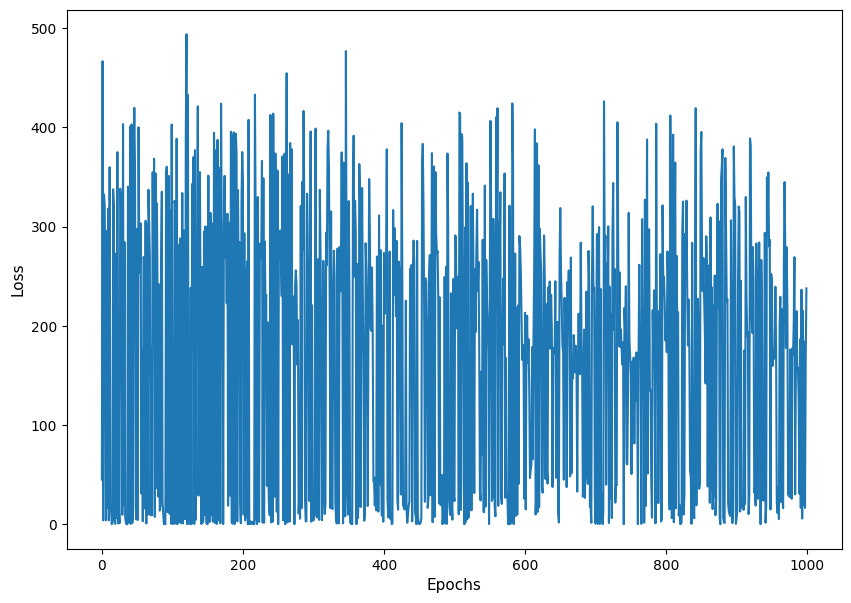

In [ ]:
epochs = 1000
losses = [] #使用串列將每一次的loss記錄下來，方便之後將loss的變化趨勢畫成圖
for i in range(epochs):
  game = Gridworld(size=4, mode='random')
  state_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0 #將3階的狀態陣列（4x4x4）轉換成向量（長度為64），並將每個值都加上一些雜訊（很小的數值）。
  state1 = torch.from_numpy(state_).float() #將NumPy陣列轉換成PyTorch張量，並存於state1中
  status = 1 #用來追蹤遊戲是否仍在繼續（『1』代表仍在繼續）
  while(status == 1):
    qval = model(state1) #執行Q網路，取得所有動作的預測Q值
    qval_ = qval.data.numpy() #將qval轉換成NumPy陣列
    if (random.random() < epsilon):
      action_ = np.random.randint(0,4) #隨機選擇一個動作（探索）
    else:
      action_ = np.argmax(qval_) #選擇Q值最大的動作（探索）
    action = action_set[action_] #將代表某動作的數字對應到makeMove()的英文字母
    game.makeMove(action) #執行之前ε—貪婪策略所選出的動作
    state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    state2 = torch.from_numpy(state2_).float() #動作執行完畢，取得遊戲的新狀態並轉換成張量
    reward = game.reward()
    with torch.no_grad():
      newQ = model(state2.reshape(1,64))
    maxQ = torch.max(newQ) #將新狀態下所輸出的Q值向量中的最大值給記錄下來
    if reward == -1:
      Y = reward + (gamma * maxQ)  #計算訓練所用的目標Q值
    else: #若reward不等於-1，代表遊戲已經結束，也就沒有下一個狀態了，因此目標Q值就等於回饋值
      Y = reward
    Y = torch.Tensor([Y]).detach()
    X = qval.squeeze()[action_] #將演算法對執行的動作所預測的Q值存進X，並使用squeeze()將qval中維度為1的階去掉 (shape[1,4]會變成[4])
    loss = loss_fn(X, Y) #計算目標Q值與預測Q值之間的誤差
    if i%100 == 0:
      print(i, loss.item())
      clear_output(wait=True)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    state1 = state2
    if abs(reward) == 10:
      status = 0 # 若 reward 的絕對值為10，代表遊戲已經分出勝負，所以設status為0
  losses.append(loss.item())
  if epsilon > 0.1:
    epsilon -= (1/epochs) #讓ε的值隨著訓練的進行而慢慢下降，直到0.1（還是要保留探索的動作）
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=11)
plt.ylabel("Loss",fontsize=11)

## HW4-2: Enhanced DQN Variants  for player  mode

### Double DQN

In [ ]:
import numpy as np
import torch
from Gridworld import Gridworld
from IPython.display import clear_output
import random
from matplotlib import pylab as plt
import copy

# Q-network 結構
class DQN(torch.nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(64, 150),
            torch.nn.ReLU(),
            torch.nn.Linear(150, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 4)
        )

    def forward(self, x):
        return self.model(x)

# 初始化主網路與目標網路
model = DQN()
target_model = copy.deepcopy(model)

loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



### Double DQN player mode訓練時的loss (可以看出有收斂且相較於Static DQN更穩定)

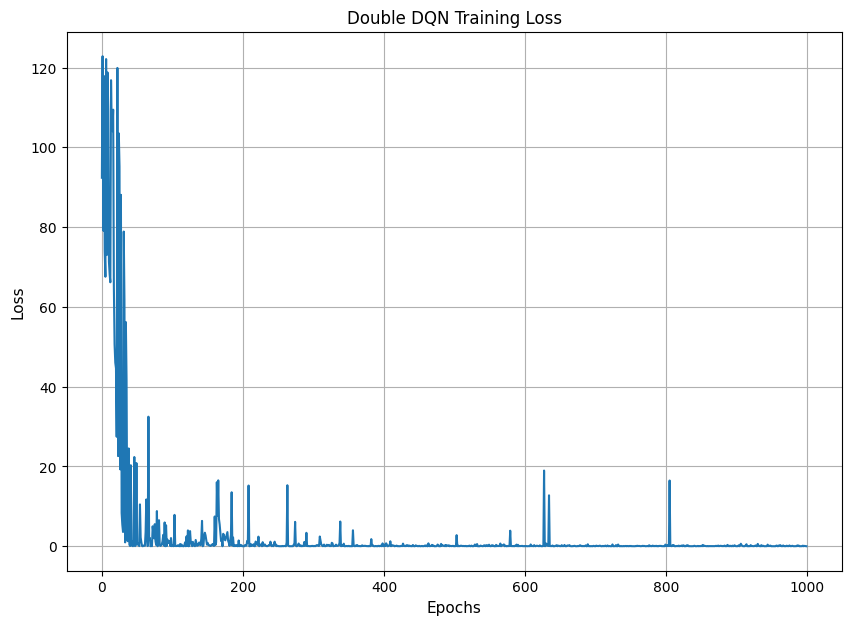

In [ ]:
# 超參數
gamma = 0.9
epsilon = 1.0
epochs = 1000
update_target_every = 20
losses = []
action_set = ['u', 'd', 'l', 'r']

for i in range(epochs):
    game = Gridworld(size=4, mode='player')
    state_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0
    state1 = torch.from_numpy(state_).float()
    status = 1

    while status == 1:
        qval = model(state1)
        qval_ = qval.data.numpy()

        if random.random() < epsilon:
            action_ = np.random.randint(0, 4)
        else:
            action_ = np.argmax(qval_)

        action = action_set[action_]
        game.makeMove(action)

        state2_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0
        state2 = torch.from_numpy(state2_).float()
        reward = game.reward()

        with torch.no_grad():
            # Double DQN：main model 決定最好的動作
            next_q_values = model(state2)
            next_action = torch.argmax(next_q_values).item()

            # target model 給出該動作的 Q 值
            target_q_values = target_model(state2)
            maxQ = target_q_values[0][next_action]

        # 計算 target Q 值
        if reward == -1:
            Y = reward + gamma * maxQ
        else:
            Y = reward

        Y = torch.tensor([Y], dtype=torch.float32).detach()
        X = qval.squeeze()[action_]
        loss = loss_fn(X, Y)

        if i % 100 == 0:
            print(i, loss.item())
            clear_output(wait=True)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        state1 = state2
        if abs(reward) == 10:
            status = 0

    losses.append(loss.item())

    # 更新 epsilon
    if epsilon > 0.1:
        epsilon -= (1 / epochs)

    # 更新 target network
    if i % update_target_every == 0:
        target_model.load_state_dict(model.state_dict())

# 畫 loss 曲線
plt.figure(figsize=(10, 7))
plt.plot(losses)
plt.xlabel("Epochs", fontsize=11)
plt.ylabel("Loss", fontsize=11)
plt.title("Double DQN Training Loss")
plt.grid()
plt.show()

### Double DQN random mode 訓練時的loss(可以看出無法收斂)

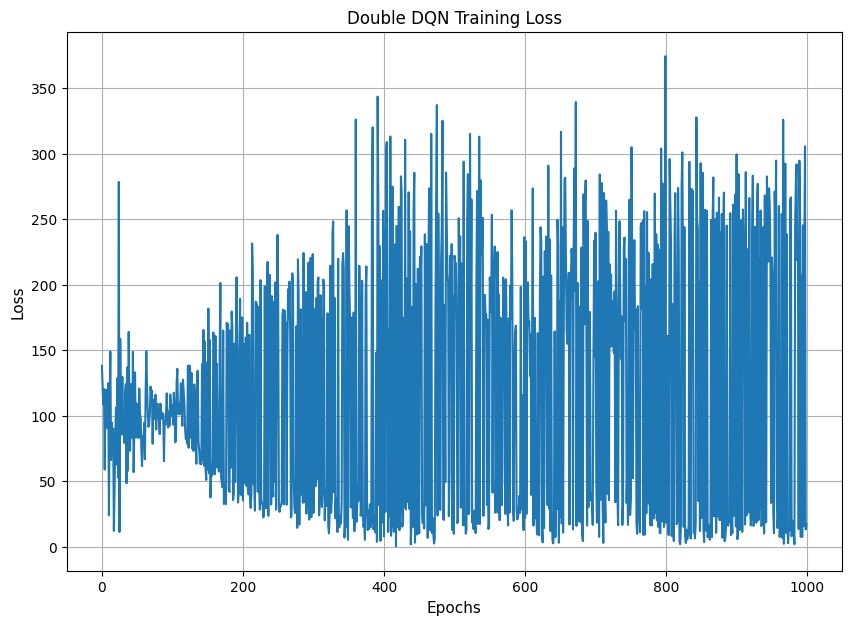

In [ ]:
# 超參數
gamma = 0.9
epsilon = 1.0
epochs = 1000
update_target_every = 20
losses = []
action_set = ['u', 'd', 'l', 'r']

for i in range(epochs):
    game = Gridworld(size=4, mode='random')
    state_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0
    state1 = torch.from_numpy(state_).float()
    status = 1

    while status == 1:
        qval = model(state1)
        qval_ = qval.data.numpy()

        if random.random() < epsilon:
            action_ = np.random.randint(0, 4)
        else:
            action_ = np.argmax(qval_)

        action = action_set[action_]
        game.makeMove(action)

        state2_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0
        state2 = torch.from_numpy(state2_).float()
        reward = game.reward()

        with torch.no_grad():
            # Double DQN：main model 決定最好的動作
            next_q_values = model(state2)
            next_action = torch.argmax(next_q_values).item()

            # target model 給出該動作的 Q 值
            target_q_values = target_model(state2)
            maxQ = target_q_values[0][next_action]

        # 計算 target Q 值
        if reward == -1:
            Y = reward + gamma * maxQ
        else:
            Y = reward

        Y = torch.tensor([Y], dtype=torch.float32).detach()
        X = qval.squeeze()[action_]
        loss = loss_fn(X, Y)

        if i % 100 == 0:
            print(i, loss.item())
            clear_output(wait=True)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        state1 = state2
        if abs(reward) == 10:
            status = 0

    losses.append(loss.item())

    # 更新 epsilon
    if epsilon > 0.1:
        epsilon -= (1 / epochs)

    # 更新 target network
    if i % update_target_every == 0:
        target_model.load_state_dict(model.state_dict())

# 畫 loss 曲線
plt.figure(figsize=(10, 7))
plt.plot(losses)
plt.xlabel("Epochs", fontsize=11)
plt.ylabel("Loss", fontsize=11)
plt.title("Double DQN Training Loss")
plt.grid()
plt.show()

## Dueling DQN

In [ ]:
import numpy as np
import torch
from Gridworld import Gridworld
from IPython.display import clear_output
import random
from matplotlib import pylab as plt
import copy

# Dueling Q-network 結構
class DuelingDQN(torch.nn.Module):
    def __init__(self):
        super(DuelingDQN, self).__init__()

        # 公用的部分（共享層）
        self.fc1 = torch.nn.Linear(64, 150)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(150, 100)

        # 狀態值部分 V(s)
        self.value_fc = torch.nn.Linear(100, 1)

        # 優勢值部分 A(s, a)
        self.advantage_fc = torch.nn.Linear(100, 4)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))

        # 計算狀態值 V(s)
        value = self.value_fc(x)

        # 計算優勢值 A(s, a)
        advantage = self.advantage_fc(x)

        # 計算 Q 值： Q(s, a) = V(s) + A(s, a) - mean(A(s))
        q_value = value + (advantage - advantage.mean(dim=1, keepdim=True))
        return q_value

# 初始化主網路與目標網路
model = DuelingDQN()
target_model = copy.deepcopy(model)

loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



### Dueling DQN player mode 訓練時的loss (可以穩定收斂)

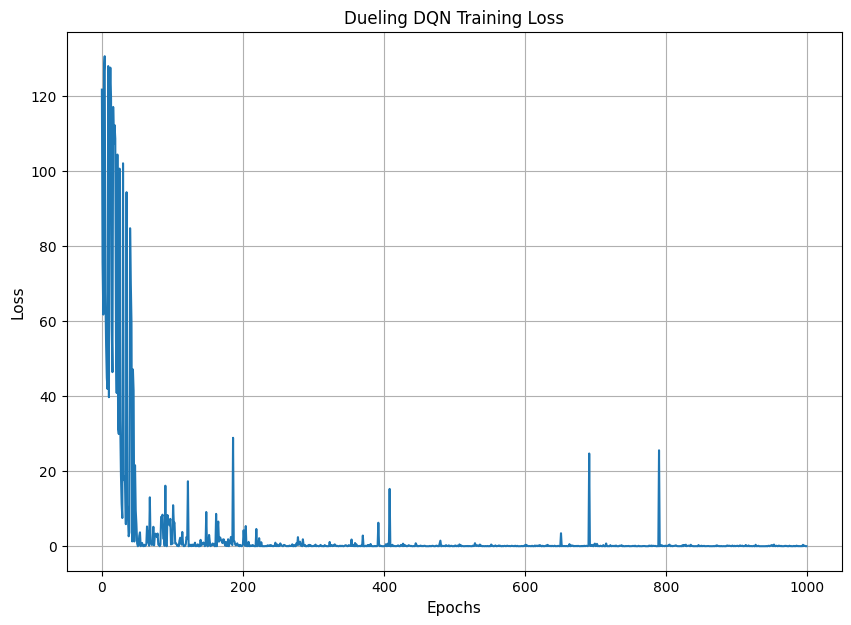

In [ ]:
# 超參數
gamma = 0.9
epsilon = 1.0
epochs = 1000
update_target_every = 20
losses = []
action_set = ['u', 'd', 'l', 'r']

for i in range(epochs):
    game = Gridworld(size=4, mode='player')
    state_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0
    state1 = torch.from_numpy(state_).float()
    status = 1

    while status == 1:
        qval = model(state1)
        qval_ = qval.data.numpy()

        if random.random() < epsilon:
            action_ = np.random.randint(0, 4)
        else:
            action_ = np.argmax(qval_)

        action = action_set[action_]
        game.makeMove(action)

        state2_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0
        state2 = torch.from_numpy(state2_).float()
        reward = game.reward()

        with torch.no_grad():
            # Double DQN：main model 決定最好的動作
            next_q_values = model(state2)
            next_action = torch.argmax(next_q_values).item()

            # target model 給出該動作的 Q 值
            target_q_values = target_model(state2)
            maxQ = target_q_values[0][next_action]

        # 計算 target Q 值
        if reward == -1:
            Y = reward + gamma * maxQ
        else:
            Y = reward

        Y = torch.tensor([Y], dtype=torch.float32).detach()
        X = qval.squeeze()[action_]
        loss = loss_fn(X, Y)

        if i % 100 == 0:
            print(i, loss.item())
            clear_output(wait=True)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        state1 = state2
        if abs(reward) == 10:
            status = 0

    losses.append(loss.item())

    # 更新 epsilon
    if epsilon > 0.1:
        epsilon -= (1 / epochs)

    # 更新 target network
    if i % update_target_every == 0:
        target_model.load_state_dict(model.state_dict())

# 畫 loss 曲線
plt.figure(figsize=(10, 7))
plt.plot(losses)
plt.xlabel("Epochs", fontsize=11)
plt.ylabel("Loss", fontsize=11)
plt.title("Dueling DQN Training Loss")
plt.grid()
plt.show()


### Dueling DQN random mode 訓練時的loss (可以看出無法收斂)

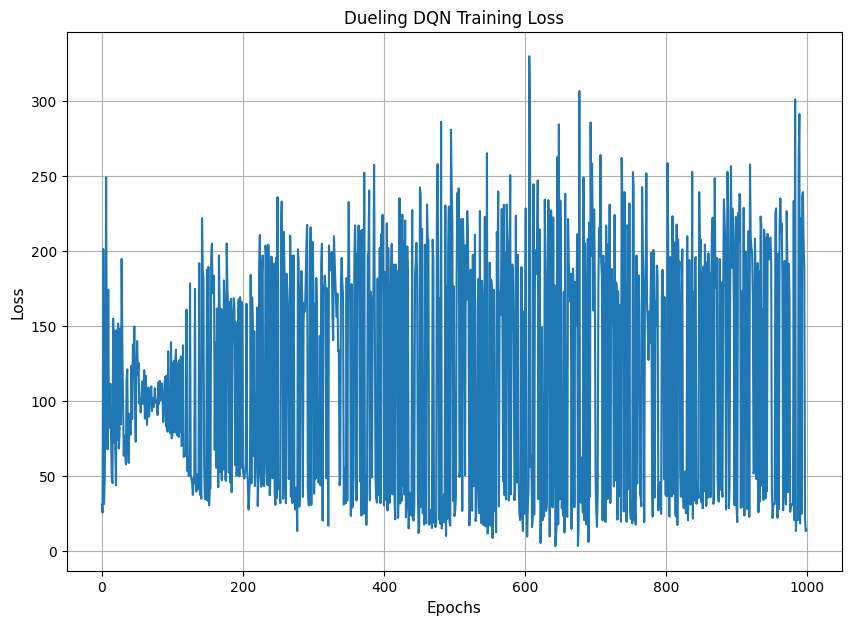

In [ ]:
# 超參數
gamma = 0.9
epsilon = 1.0
epochs = 1000
update_target_every = 20
losses = []
action_set = ['u', 'd', 'l', 'r']

for i in range(epochs):
    game = Gridworld(size=4, mode='random')
    state_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0
    state1 = torch.from_numpy(state_).float()
    status = 1

    while status == 1:
        qval = model(state1)
        qval_ = qval.data.numpy()

        if random.random() < epsilon:
            action_ = np.random.randint(0, 4)
        else:
            action_ = np.argmax(qval_)

        action = action_set[action_]
        game.makeMove(action)

        state2_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0
        state2 = torch.from_numpy(state2_).float()
        reward = game.reward()

        with torch.no_grad():
            # Double DQN：main model 決定最好的動作
            next_q_values = model(state2)
            next_action = torch.argmax(next_q_values).item()

            # target model 給出該動作的 Q 值
            target_q_values = target_model(state2)
            maxQ = target_q_values[0][next_action]

        # 計算 target Q 值
        if reward == -1:
            Y = reward + gamma * maxQ
        else:
            Y = reward

        Y = torch.tensor([Y], dtype=torch.float32).detach()
        X = qval.squeeze()[action_]
        loss = loss_fn(X, Y)

        if i % 100 == 0:
            print(i, loss.item())
            clear_output(wait=True)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        state1 = state2
        if abs(reward) == 10:
            status = 0

    losses.append(loss.item())

    # 更新 epsilon
    if epsilon > 0.1:
        epsilon -= (1 / epochs)

    # 更新 target network
    if i % update_target_every == 0:
        target_model.load_state_dict(model.state_dict())

# 畫 loss 曲線
plt.figure(figsize=(10, 7))
plt.plot(losses)
plt.xlabel("Epochs", fontsize=11)
plt.ylabel("Loss", fontsize=11)
plt.title("Dueling DQN Training Loss")
plt.grid()
plt.show()


## HW4-3: Enhance DQN for random mode WITH Training Tips

加入
1. gradient clipping

2. learning rate scheduling

3. early stopping

In [ ]:
pip install pytorch-lightning

### Dueling DQN + pytorch lightning player mode (可以穩定收斂)

INFO:pytorch_lightning.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type       | Params | Mode 
-----------------------------------------------------------
0 | net                 | Sequential | 24.9 K | train
1 | value_fc            | Linear     | 101    | train
2 | advantage_fc        | Linear     | 404    | train
3 | target_net          | Sequential | 24.9 K | train
4 | target_value_fc     | Linear     | 101    | train
5 | target_advantage_fc | Linear     

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved. New best score: 15.107
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 15.038 >= min_delta = 0.0. New best score: 0.069
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.051
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.041
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.036
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.029
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.023
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.017
INFO:pytorch_light

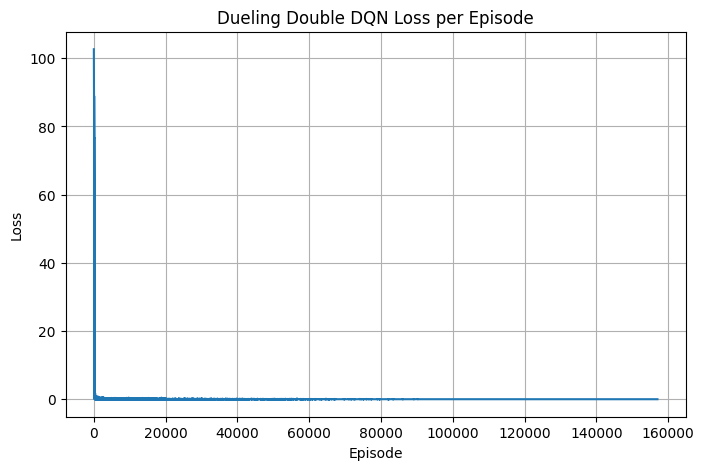

In [ ]:
import numpy as np
import torch
import random
import copy
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from matplotlib import pyplot as plt
from Gridworld import Gridworld

# —— 1) Dataset：仅触发训练步数
class EpisodeDataset(Dataset):
    def __init__(self, epochs):
        self.epochs = epochs
    def __len__(self):
        return self.epochs
    def __getitem__(self, idx):
        return idx

# —— 2) LightningModule：Dueling Double DQN
class DuelingDQNModule(pl.LightningModule):
    def __init__(self, epochs=1000, batch_size=1):
        super().__init__()
        # 共享层
        self.net = torch.nn.Sequential(
            torch.nn.Linear(64, 150), torch.nn.ReLU(),
            torch.nn.Linear(150, 100), torch.nn.ReLU()
        )
        self.value_fc     = torch.nn.Linear(100, 1)
        self.advantage_fc = torch.nn.Linear(100, 4)

        # 目标网络深拷贝（在未编译前）
        self.target_net         = copy.deepcopy(self.net)
        self.target_value_fc     = copy.deepcopy(self.value_fc)
        self.target_advantage_fc = copy.deepcopy(self.advantage_fc)

        # —— 【移除】 torch.compile(self.net) 以避免键名不一致

        # 损失与超参数
        self.loss_fn = torch.nn.MSELoss()
        self.gamma = 0.9
        self.epsilon = 1.0
        self.update_target_every = 20
        self.epochs = epochs
        self.batch_size = batch_size
        self.action_set = ['u','d','l','r']
        self.episode_losses = []

    def forward(self, x):
        x = self.net(x)
        v = self.value_fc(x)
        a = self.advantage_fc(x)
        # Dueling 组合
        return v + (a - a.mean(dim=1, keepdim=True))

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="min", factor=0.5, patience=10
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "train_loss",
                "interval": "epoch",
                "frequency": 1
            },
        }

    def training_step(self, batch, batch_idx):
        # 每个 batch 代表一次完整 episode
        _ = batch
        game = Gridworld(size=4, mode='player')
        st = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        state = torch.from_numpy(st).float().to(self.device)

        loss = torch.tensor(0.0, device=self.device)
        done = False
        while not done:
            q = self(state)  # [1,4]
            q_np = q.detach().cpu().to(torch.float32).numpy()[0]
            if random.random() < self.epsilon:
                act_i = random.randint(0,3)
            else:
                act_i = int(np.argmax(q_np))

            game.makeMove(self.action_set[act_i])
            nxt = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
            next_state = torch.from_numpy(nxt).float().to(self.device)
            reward = game.reward()

            with torch.no_grad():
                # Double DQN：主网选动作，目标网评估
                nq = self(next_state)
                next_act = int(torch.argmax(nq, dim=1)[0])

                tx = self.target_net(next_state)
                tv = self.target_value_fc(tx)
                ta = self.target_advantage_fc(tx)
                q_t = tv + (ta - ta.mean(dim=1, keepdim=True))
                maxQ = q_t[0, next_act]

            y = reward + (self.gamma * maxQ if reward == -1 else 0.0)
            y = torch.tensor([y], dtype=torch.float32, device=self.device)
            x_val = q[0, act_i]
            loss = self.loss_fn(x_val, y)

            state = next_state
            if abs(reward) == 10:
                done = True

        # 记录 & 日志
        self.log("train_loss", loss, on_epoch=True)
        self.episode_losses.append(loss.item())
        return loss

    def on_train_epoch_end(self):
        # ε-linearly decay
        if self.epsilon > 0.1:
            self.epsilon -= 1/self.epochs
        # 更新目标网络
        if (self.current_epoch + 1) % self.update_target_every == 0:
            self.target_net.load_state_dict(self.net.state_dict())
            self.target_value_fc.load_state_dict(self.value_fc.state_dict())
            self.target_advantage_fc.load_state_dict(self.advantage_fc.state_dict())

    def train_dataloader(self):
        return DataLoader(
            EpisodeDataset(self.epochs),
            batch_size=self.batch_size,
            num_workers=8,
            pin_memory=True,
            shuffle=False
        )

# —— 启动训练
early_stop = EarlyStopping(monitor="train_loss", mode="min", patience=20, verbose=True)
lr_monitor = LearningRateMonitor(logging_interval='epoch')

model = DuelingDQNModule(epochs=1000, batch_size=1)
trainer = pl.Trainer(
    max_epochs=model.epochs,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
    precision=16,                  # AMP
    benchmark=True,
    deterministic=False,
    accumulate_grad_batches=4,     # 梯度累积
    gradient_clip_val=0.5,         # 梯度裁剪
    callbacks=[early_stop, lr_monitor],
    num_sanity_val_steps=0
)
trainer.fit(model)

# —— 绘制 Loss 曲线
plt.figure(figsize=(8,5))
plt.plot(model.episode_losses)
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.title("Dueling Double DQN Loss per Episode")
plt.grid()
plt.show()


### Dueling DQN + pytorch lightning random mode (可以穩定收斂)

INFO:pytorch_lightning.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type       | Params | Mode 
-----------------------------------------------------------
0 | net                 | Sequential | 24.9 K | train
1 | value_fc            | Linear     | 101    | train
2 | advantage_fc        | Linear     | 404    | train
3 | target_net          | Sequential | 24.9 K | train
4 | target_value_fc     | Linear     | 101    | train
5 | target_advantage_fc | Linear     

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved. New best score: 99.541
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 2.857 >= min_delta = 0.0. New best score: 96.683
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 11.150 >= min_delta = 0.0. New best score: 85.534
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 15.941 >= min_delta = 0.0. New best score: 69.592
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 20.682 >= min_delta = 0.0. New best score: 48.911
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 22.598 >= min_delta = 0.0. New best score: 26.313
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 7.980 >= min_delta = 0.0. New best score: 18.333
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 4.966 >= min_delta = 0.0. New best score: 13.367
INFO:pyt

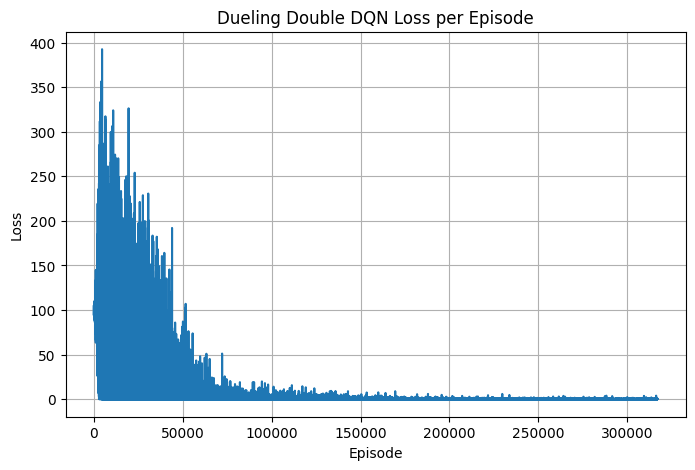

In [ ]:
import numpy as np
import torch
import random
import copy
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from matplotlib import pyplot as plt
from Gridworld import Gridworld

# —— 1) Dataset：仅触发训练步数
class EpisodeDataset(Dataset):
    def __init__(self, epochs):
        self.epochs = epochs
    def __len__(self):
        return self.epochs
    def __getitem__(self, idx):
        return idx

# —— 2) LightningModule：Dueling Double DQN
class DuelingDQNModule(pl.LightningModule):
    def __init__(self, epochs=1000, batch_size=1):
        super().__init__()
        # 共享层
        self.net = torch.nn.Sequential(
            torch.nn.Linear(64, 150), torch.nn.ReLU(),
            torch.nn.Linear(150, 100), torch.nn.ReLU()
        )
        self.value_fc     = torch.nn.Linear(100, 1)
        self.advantage_fc = torch.nn.Linear(100, 4)

        # 目标网络深拷贝（在未编译前）
        self.target_net         = copy.deepcopy(self.net)
        self.target_value_fc     = copy.deepcopy(self.value_fc)
        self.target_advantage_fc = copy.deepcopy(self.advantage_fc)

        # —— 【移除】 torch.compile(self.net) 以避免键名不一致

        # 损失与超参数
        self.loss_fn = torch.nn.MSELoss()
        self.gamma = 0.9
        self.epsilon = 1.0
        self.update_target_every = 20
        self.epochs = epochs
        self.batch_size = batch_size
        self.action_set = ['u','d','l','r']
        self.episode_losses = []

    def forward(self, x):
        x = self.net(x)
        v = self.value_fc(x)
        a = self.advantage_fc(x)
        # Dueling 组合
        return v + (a - a.mean(dim=1, keepdim=True))

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="min", factor=0.5, patience=10
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "train_loss",
                "interval": "epoch",
                "frequency": 1
            },
        }

    def training_step(self, batch, batch_idx):
        # 每个 batch 代表一次完整 episode
        _ = batch
        game = Gridworld(size=4, mode='random')
        st = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        state = torch.from_numpy(st).float().to(self.device)

        loss = torch.tensor(0.0, device=self.device)
        done = False
        while not done:
            q = self(state)  # [1,4]
            q_np = q.detach().cpu().to(torch.float32).numpy()[0]
            if random.random() < self.epsilon:
                act_i = random.randint(0,3)
            else:
                act_i = int(np.argmax(q_np))

            game.makeMove(self.action_set[act_i])
            nxt = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
            next_state = torch.from_numpy(nxt).float().to(self.device)
            reward = game.reward()

            with torch.no_grad():
                # Double DQN：主网选动作，目标网评估
                nq = self(next_state)
                next_act = int(torch.argmax(nq, dim=1)[0])

                tx = self.target_net(next_state)
                tv = self.target_value_fc(tx)
                ta = self.target_advantage_fc(tx)
                q_t = tv + (ta - ta.mean(dim=1, keepdim=True))
                maxQ = q_t[0, next_act]

            y = reward + (self.gamma * maxQ if reward == -1 else 0.0)
            y = torch.tensor([y], dtype=torch.float32, device=self.device)
            x_val = q[0, act_i]
            loss = self.loss_fn(x_val, y)

            state = next_state
            if abs(reward) == 10:
                done = True

        # 记录 & 日志
        self.log("train_loss", loss, on_epoch=True)
        self.episode_losses.append(loss.item())
        return loss

    def on_train_epoch_end(self):
        # ε-linearly decay
        if self.epsilon > 0.1:
            self.epsilon -= 1/self.epochs
        # 更新目标网络
        if (self.current_epoch + 1) % self.update_target_every == 0:
            self.target_net.load_state_dict(self.net.state_dict())
            self.target_value_fc.load_state_dict(self.value_fc.state_dict())
            self.target_advantage_fc.load_state_dict(self.advantage_fc.state_dict())

    def train_dataloader(self):
        return DataLoader(
            EpisodeDataset(self.epochs),
            batch_size=self.batch_size,
            num_workers=8,
            pin_memory=True,
            shuffle=False
        )

# —— 启动训练
early_stop = EarlyStopping(monitor="train_loss", mode="min", patience=20, verbose=True)
lr_monitor = LearningRateMonitor(logging_interval='epoch')

model = DuelingDQNModule(epochs=1000, batch_size=1)
trainer = pl.Trainer(
    max_epochs=model.epochs,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
    precision=16,                  # AMP
    benchmark=True,
    deterministic=False,
    accumulate_grad_batches=4,     # 梯度累积
    gradient_clip_val=0.5,         # 梯度裁剪
    callbacks=[early_stop, lr_monitor],
    num_sanity_val_steps=0
)
trainer.fit(model)

# —— 绘制 Loss 曲线
plt.figure(figsize=(8,5))
plt.plot(model.episode_losses)
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.title("Dueling Double DQN Loss per Episode")
plt.grid()
plt.show()
